# Import Lib

In [1]:
import pandas as pd
import numpy as np
import cv2

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential

# useful for getting number of output classes
from glob import glob

import matplotlib.pyplot as plt
from matplotlib import image
from PIL import Image

# Splitting folder into test and train

### Run once 

In [2]:
import splitfolders

# Split with any ratio in train, val, test set
# we do not split it in validation set since the dataset is quite small and we are not doing any hyperparameter tuning
splitfolders.ratio("archive/colored_images", output="archive/colored_images_mod",
    seed=1337, ratio=(0.8, 0, 0.2), group_prefix=None, move=False) 

# Dataset

In [2]:
train_path = 'archive/new_dataset/train'
test_path = 'archive/new_dataset/test'

In [3]:
folders = glob('archive/new_dataset/train/*')

In [4]:
folders

[]

In [4]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 15,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [5]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

Found 2929 images belonging to 5 classes.


In [6]:
test_set = test_datagen.flow_from_directory(test_path,
                                           target_size = (224, 224),
                                           batch_size = 64,
                                           class_mode = 'categorical')

Found 733 images belonging to 5 classes.


# VGG19

In [7]:
IMAGE_SHAPE = [224,224]

# we need to keep the weights same as the original model and just drop first and last layer
# Here we will be using imagenet weights
vgg = VGG19(input_shape=IMAGE_SHAPE + [3], weights='imagenet', include_top=False)

In [8]:
# don't train existing weights 
for layer in vgg.layers:
    layer.trainable = False

In [9]:
# changing the last layers since we need 5 classes rather than 1000 which it already does
x = Flatten()(vgg.output)
x = Dense(521, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [11]:
from tensorflow.keras.optimizers import Adam
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer=Adam(learning_rate=0.001),
  metrics=['accuracy']
)

In [24]:
# fit the model
# Run the cell
# It will take some time to execute, better to run on the gpu
# in our case we run it on gtx 1650ti
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
)

Epoch 1/50
46/46 [==============================] - 95s 2s/step - loss: 1.1861 - accuracy: 0.6122 - val_loss: 0.9438 - val_accuracy: 0.6317
Epoch 2/50
46/46 [==============================] - 42s 906ms/step - loss: 0.8232 - accuracy: 0.7108 - val_loss: 0.7556 - val_accuracy: 0.7080
Epoch 3/50
46/46 [==============================] - 43s 925ms/step - loss: 0.8398 - accuracy: 0.6961 - val_loss: 0.8996 - val_accuracy: 0.6508
Epoch 4/50
46/46 [==============================] - 44s 947ms/step - loss: 0.7340 - accuracy: 0.7320 - val_loss: 0.7856 - val_accuracy: 0.6794
Epoch 5/50
46/46 [==============================] - 46s 989ms/step - loss: 0.6987 - accuracy: 0.7385 - val_loss: 0.8434 - val_accuracy: 0.7381
Epoch 6/50
46/46 [==============================] - 49s 1s/step - loss: 0.7786 - accuracy: 0.7217 - val_loss: 0.8805 - val_accuracy: 0.6698
Epoch 7/50
46/46 [==============================] - 48s 1s/step - loss: 0.7477 - accuracy: 0.7279 - val_loss: 0.7703 - val_accuracy: 0.7285
Epoch 8/

# Plot

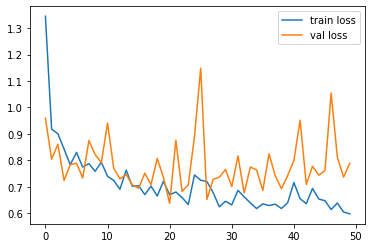

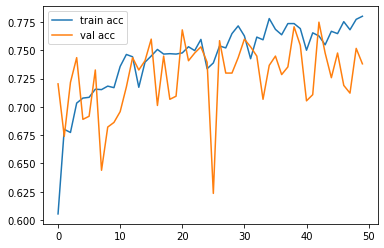

In [12]:
#old dataset
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

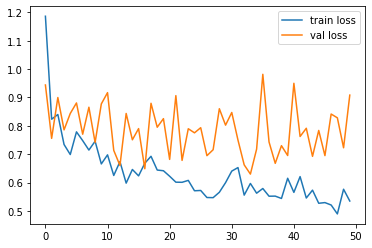

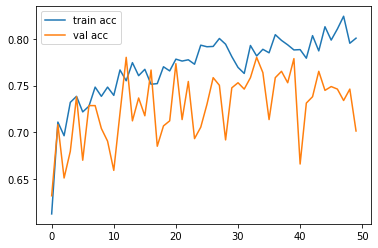

In [25]:
#new dataset
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()